# Setup

This is the stuff you have to edit; the rest of the sections can run as-is after you've set the needed parameters.

---

`coord_suffix` must align with 
* the sub-directory (corresponds to region, e.g., "mucosa") under the `dir_coord` directory where the Xenium Explorer-exported selection files are stored, and
* the suffixes of the coordinate selection files (see file naming conventions below).
  
The `AnnData` objects created will have this suffix as well (e.g., `Uninflamed-50452A_mucosa.h5ad`).

---

Selection files should be named by this convention:
`<library_id>_<coord_suffix>.csv`.

For example, if `dir_coord` is `.../coordinates/mucosa`, the mucosa selection file for sample 50452A should be under `.../coordinates/mucosa/50452A_mucosa.csv`. 

More specifically, if the coordinates directory is under `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates`, and the selection region is "mucosa,"`dir_coord` should be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa`, and the full file path for this sample would be `/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/mucosa/50452A_mucosa.csv`.

---

**As with any other file naming schema, suffixes/directory names should not any special characters other than underscores (`_`) (no periods, dashes, spaces, etc.).**

N.B. In the above explanation, `library_id` refers to library/original sample ID without condition (e.g., "50452A", not "Uninflamed-50452A" like in other places). Remember that `coord_suffix` should also be the name of the parent directory of the coordinate file. I include this information in both the directory and file name to prevent mix-ups should files be moved or placed in the wrong folder.

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import math
import functools
import traceback
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import corescpy as cr

# Main
write_object = True  # change to True when you're ready to save objects
coord_suffix = "submucosa"  # sub-directory & file/object suffix

# Process Options
panel_id = "TUQ97N"  # Xenium panel ID
show_cols = [cr.pp.COL_SUBJECT]  # only change if not TUQ97N
cso = cr.pp.COL_SAMPLE_ID_O  # original library ID; change if not TUQ97N
col_sample = cr.pp.COL_SAMPLE_ID  # object sample ID; change if not TUQ97N
# libs = [  # sample IDs from patients for whom we have all conditions
#     "50452A", "50452B", "50452C",  # old segmentation
#     "50006A", "50006B", "50006C",  # rest are new segmentation
#     "50217A", "50217B", "50217C",
#     "50336B", "50336C", "50336A",
#     "50403A2", "50403B", "50403C1"
# ]  # excludes low-quality sample/condition replicates 50403A1 & 50403C2
libs = ["50006A", "50006B", "50217A", "50217B", "50336B", "50336C",
        "50403B", "50403A2"]  # just inflamed/uninflamed (no strictures)
# libs = None  # to run all available samples
input_suffix = ""  # in case want to crop objects with some suffix
# due to creation of a subsidiary object, e.g., for
# "Stricture-50452C_downsampled.h5ad"
# input_suffix would be "_downsampled". For "main" objects, input_suffix=""
plot = True  # could slow process down if large samples/cropped area

# Files & Directories
dir_entry = "/mnt/cho_lab/disk2"  # Spark writeable data directory
mdf = str("/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/"
          "samples.csv")  # metadata file path (for now; will soon be on NFS)
dir_writeable = os.path.join(
    dir_entry, f"{os.getlogin()}/data/shared-xenium-library")  # your folder
direc = "/mnt/cho_lab/bbdata2/"  # mounted NFS with data
dir_data = os.path.join(direc, f"outputs/{panel_id}")
out_dir = os.path.join(
    dir_writeable, f"outputs/{panel_id}/nebraska")  # object output directory
dir_coord = os.path.join(
    out_dir, "coordinates", coord_suffix)  # coordinates (also maybe NFS soon)

# Constants (Shouldn't Need Edits Unless Extreme Process Changes)
col_obj = cr.pp.COL_OBJECT
out_sub = os.path.join(out_dir, "objects_cropped",
                       coord_suffix)  # sub-directory: cropped h5ad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Find Files & Load Metadata

Allows us to find the object IDs (e.g., for TUQ97N, object IDs are in the format <condition (Inflamed/Uninflamed/Stricture)><block_id>) corresponding to the sample IDs.

In [2]:
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths
os.makedirs(out_dir, exist_ok=True)  # make output directory if needed
os.makedirs(out_sub, exist_ok=True)  # make sub-directory to write new object
metadata = cr.pp.get_metadata_cho(direc, mdf, panel_id=panel_id, samples=libs)
metadata[show_cols]

,Name
Sample,
Inflamed-50006A,50006
Uninflamed-50006B,50006
Inflamed-50217A,50217
Uninflamed-50217B,50217
Inflamed-50336B,50336
Uninflamed-50336C,50336
Inflamed-50403B,50403
Uninflamed-50403A2,50403


# Subset Data by Coordinate Files & Write Cropped Objects

Subset the data by coordinates (`corescpy` can use Xenium Explorer-exported manual selection files to get those coordinates) and then write the cropped objects to `out_dir/<coord_suffix>`.



****************************************
50006A
****************************************




Data: /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-007/output-XETG00189__0022407__50006A-TUQ97N-EA__20240411__205514
Object: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/Inflamed-50006A.h5ad
Coordinates: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/coordinates/submucosa/50006A_submucosa.csv
Ouput: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/objects_cropped/submucosa/Inflamed-50006A_submucosa.h5ad


<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-007/output-XETG00189__0022407__50006A-TUQ97N-EA__20240411__205514/
         cell_feature_matrix.h5                                                                                    




Counts: Initial


	Observations: 297656

	Genes: 469







 AnnData object with n_obs × n_vars = 297656 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols                                           
ABCA7         ENSG00000064687  Gene Expression  Unknown
ACTA2         ENSG00000107796  Gene Expression  Unknown
ACTG2         ENSG00000163017  Gene Expression  Unknown
ADAM15        ENSG00000143537  Gene Expression  Unknown
ADAM28        ENSG00000042980  Gene Expression  Unknown 

 



col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="Sample"
col_b

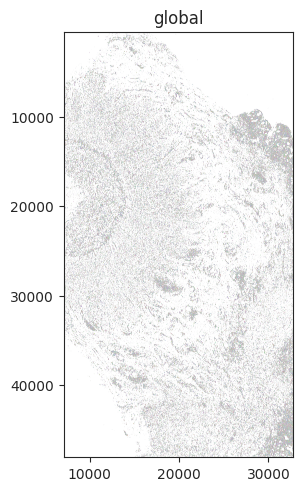

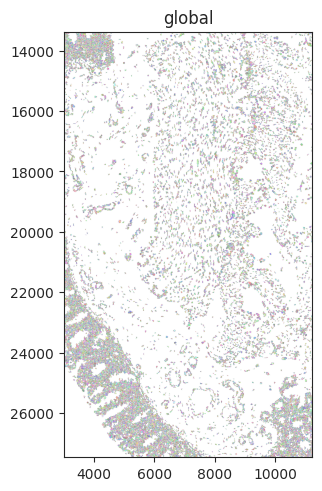

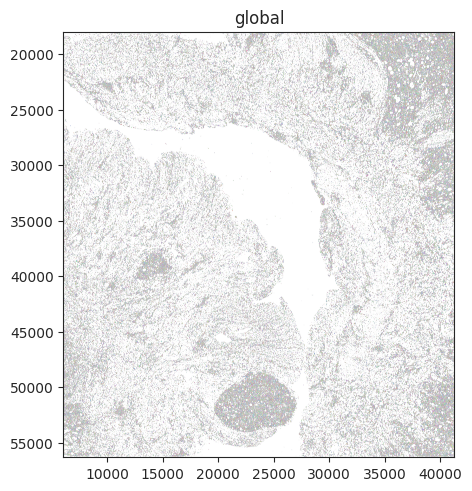

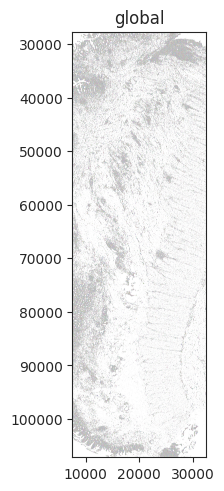

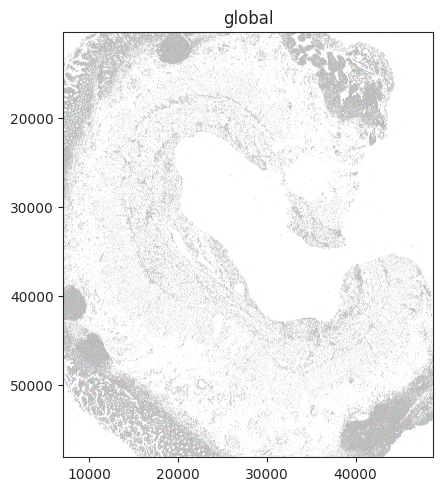

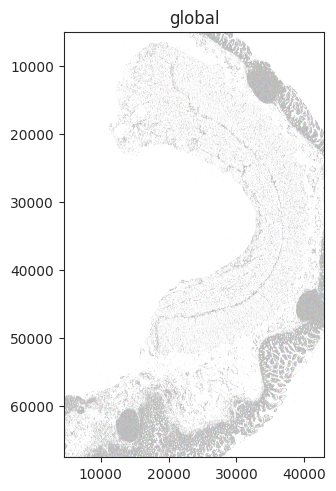

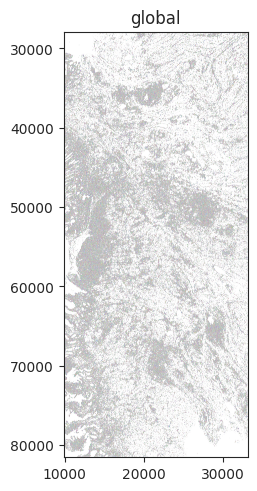

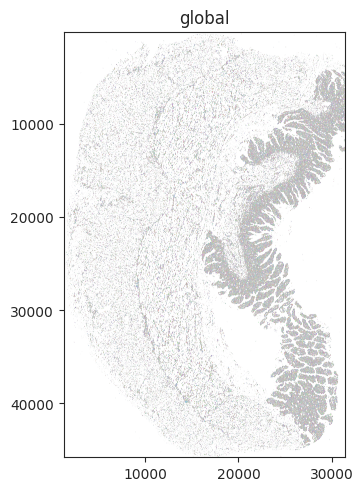

In [10]:
%%time

for s in libs:  # iterate samples
    print(f"\n\n{'*' * 40}\n{s}\n{'*' * 40}\n\n")
    fff = os.path.join(dir_data, np.array(files)[np.where([
        s == os.path.basename(x).split("__")[2].split("-")[0]
        for x in files])[0][0]])  # sample's Xenium data directory path
    lib = metadata.reset_index().set_index(cso).loc[s][col_sample]
    file_obj_proc = os.path.join(out_dir, f"{lib}{input_suffix}.h5ad")
    file_coord = os.path.join(dir_coord, s + f"_{coord_suffix}.csv")
    file_obj_crop = os.path.join(out_sub, f"{lib}_{coord_suffix}.h5ad")
    if not os.path.exists(file_coord):
        print(f"*** Coordinate file {file_coord} doesn't exist")
        continue
    print(f"\n\nData: {fff}\nObject: {file_obj_proc}"
          f"\nCoordinates: {file_coord}\nOuput: {file_obj_crop}")
    self = cr.Spatial(fff, library_id=lib)  # load original data
    self.update_from_h5ad(file_obj_proc)  # update with processed object
    try:
        sdata = self.crop(file_coord)  # crop data to coordinates
        if plot:
            try:
                sdata.pl.render_labels("cell_labels").pl.show()  # plot crop
            except Exception:
                pass
        self.adata = sdata
        if write_object is True:
            self.write(file_obj_crop)  # write cropped
    except Exception:
        print(traceback.format_exc(), f"Cropping \n\n{s} failed!")